In [1]:
from pathlib import Path
from datatree import DataTree
import datatree
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

import valenspy as vp
from valenspy.cf_checks import cf_status, is_cf_compliant

# Import data

We will start by loading in the data from all 4 simulations. This data will be grouped in a DataTree structure, as they are defined on different grids but we want to perform the same calculations on all of them. To prevent the notebook from running to long, we will only use data from the year 2021.

In [2]:
levels = ["level01", "level03", "level04"]
data_tree = {}
for level in levels:
    print(level)
    files = list(Path(f"/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc45263_wout/DYDOCASE/export/long/{level}/pr/output/").rglob('*2021_??.nc'))
    ds = xr.open_mfdataset(files, combine='by_coords', chunks="auto")
    data_tree[level] = ds

level01
level03
level04


In [3]:
dt = DataTree.from_dict(data_tree)
dt

DataTree('None', parent=None)
├── DataTree('level01')
│       Dimensions:             (time: 8760, y: 251, x: 251, bnds: 2, nv: 4)
│       Coordinates:
│         * x                   (x) float64 2kB -3.125e+06 -3.1e+06 ... 3.125e+06
│         * y                   (y) float64 2kB 2.974e+06 2.999e+06 ... 9.224e+06
│         * time                (time) datetime64[ns] 70kB 2021-01-01T01:00:00 ... 20...
│           time_bnds           (time, bnds) datetime64[ns] 140kB dask.array<chunksize=(744, 2), meta=np.ndarray>
│           lon                 (y, x) float64 504kB dask.array<chunksize=(251, 251), meta=np.ndarray>
│           lat                 (y, x) float64 504kB dask.array<chunksize=(251, 251), meta=np.ndarray>
│           lambert_projection  int64 8B 0
│           lat_bounds          (y, x, nv) float64 2MB dask.array<chunksize=(251, 251, 4), meta=np.ndarray>
│           lon_bounds          (y, x, nv) float64 2MB dask.array<chunksize=(251, 251, 4), meta=np.ndarray>
│       Dimensions without coordinates: bnds, nv
│       Data variables:
│           pr                  (time, y, x) float64 4GB dask.array<chunksize=(528, 178, 178), meta=np.ndarray>
│       Attributes:
│           Conventions:  CF-1.11
│           title:        Climate model data
│           institution:  Ghent University
│           source:       ALARO-1 (CY43T2) - SURFEX v8.0
│           history:      2024-06-21 13:44:13.757109 Python
│           references:   
│           comments:     
├── DataTree('level03')
│       Dimensions:             (time: 8760, y: 421, x: 421, bnds: 2, nv: 4)
│       Coordinates:
│         * x                   (x) float64 3kB -8.4e+05 -8.36e+05 ... 8.36e+05 8.4e+05
│         * y                   (y) float64 3kB 5.572e+06 5.576e+06 ... 7.252e+06
│         * time                (time) datetime64[ns] 70kB 2021-01-01T01:00:00 ... 20...
│           time_bnds           (time, bnds) datetime64[ns] 140kB dask.array<chunksize=(744, 2), meta=np.ndarray>
│           lon                 (y, x) float64 1MB dask.array<chunksize=(421, 421), meta=np.ndarray>
│           lat                 (y, x) float64 1MB dask.array<chunksize=(421, 421), meta=np.ndarray>
│           lambert_projection  int64 8B 0
│           lat_bounds          (y, x, nv) float64 6MB dask.array<chunksize=(421, 421, 4), meta=np.ndarray>
│           lon_bounds          (y, x, nv) float64 6MB dask.array<chunksize=(421, 421, 4), meta=np.ndarray>
│       Dimensions without coordinates: bnds, nv
│       Data variables:
│           pr                  (time, y, x) float64 12GB dask.array<chunksize=(374, 211, 211), meta=np.ndarray>
│       Attributes:
│           Conventions:  CF-1.11
│           title:        Climate model data
│           institution:  Ghent University
│           source:       ALARO-1 (CY43T2) - SURFEX v8.0
│           history:      2024-06-21 13:53:49.380297 Python
│           references:   
│           comments:     
└── DataTree('level04')
        Dimensions:             (time: 8760, y: 421, x: 421, bnds: 2, nv: 4)
        Coordinates:
          * x                   (x) float64 3kB -2.73e+05 -2.717e+05 ... 2.73e+05
          * y                   (y) float64 3kB 6.098e+06 6.099e+06 ... 6.644e+06
          * time                (time) datetime64[ns] 70kB 2021-01-01T01:00:00 ... 20...
            time_bnds           (time, bnds) datetime64[ns] 140kB dask.array<chunksize=(744, 2), meta=np.ndarray>
            lon                 (y, x) float64 1MB dask.array<chunksize=(421, 421), meta=np.ndarray>
            lat                 (y, x) float64 1MB dask.array<chunksize=(421, 421), meta=np.ndarray>
            lambert_projection  int64 8B 0
            lat_bounds          (y, x, nv) float64 6MB dask.array<chunksize=(421, 421, 4), meta=np.ndarray>
            lon_bounds          (y, x, nv) float64 6MB dask.array<chunksize=(421, 421, 4), meta=np.ndarray>
        Dimensions without coordinates: bnds, nv
        Data variables:
            pr                  (time, y

## Spatial spin-up of precipitation

Evaluating the spatial spin-up of precipitation as done by 

`Roberge, François, Alejandro Di Luca, René Laprise, Philippe Lucas-Picher, and Julie Thériault. “Spatial Spin-up of Precipitation in Limited-Area Convection-Permitting Simulations over North America Using the CRCM6/GEM5.0 Model.” Geoscientific Model Development 17, no. 4 (February 20, 2024): 1497–1510. https://doi.org/10.5194/gmd-17-1497-2024.`

First calculate the mean precipitation fields in meridional direction, $$\bar{p}_{i}^{j} = \frac{1}{(1-2A)*N_{j}} \sum_{j=A*N_{j}}^{(1-A)*N_{j}} p_{i,j},$$
where $p_{i,j}$ is the time average precipitation field at grid point ($i,j$), $N_{j}$ is the number of grid points in the j-direction, and $A$ is the fraction of grid points to be excluded at the boundaries. The same calculation is done in the zonal direction.


In [11]:
ds = dt.level01.to_dataset()
ds

<xarray.Dataset> Size: 4GB
Dimensions:             (time: 8760, y: 251, x: 251, bnds: 2, nv: 4)
Coordinates:
  * x                   (x) float64 2kB -3.125e+06 -3.1e+06 ... 3.125e+06
  * y                   (y) float64 2kB 2.974e+06 2.999e+06 ... 9.224e+06
  * time                (time) datetime64[ns] 70kB 2021-01-01T01:00:00 ... 20...
    time_bnds           (time, bnds) datetime64[ns] 140kB dask.array<chunksize=(744, 2), meta=np.ndarray>
    lon                 (y, x) float64 504kB dask.array<chunksize=(251, 251), meta=np.ndarray>
    lat                 (y, x) float64 504kB dask.array<chunksize=(251, 251), meta=np.ndarray>
    lambert_projection  int64 8B 0
    lat_bounds          (y, x, nv) float64 2MB dask.array<chunksize=(251, 251, 4), meta=np.ndarray>
    lon_bounds          (y, x, nv) float64 2MB dask.array<chunksize=(251, 251, 4), meta=np.ndarray>
Dimensions without coordinates: bnds, nv
Data variables:
    pr                  (time, y, x) float64 4GB dask.array<chunksize=(528, 178, 178), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.11
    title:        Climate model data
    institution:  Ghent University
    source:       ALARO-1 (CY43T2) - SURFEX v8.0
    history:      2024-06-21 13:44:13.757109 Python
    references:   
    comments:

In [35]:
ds = ds.where(ds["lat"] > 40).where(ds["lat"] < 53).where(ds["lon"] > 2.5).where(ds["lon"] < 6.5)
ds

<xarray.Dataset> Size: 4GB
Dimensions:             (time: 8760, y: 251, x: 251, bnds: 2, nv: 4)
Coordinates:
  * x                   (x) float64 2kB -3.125e+06 -3.1e+06 ... 3.125e+06
  * y                   (y) float64 2kB 2.974e+06 2.999e+06 ... 9.224e+06
  * time                (time) datetime64[ns] 70kB 2021-01-01T01:00:00 ... 20...
    time_bnds           (time, bnds) datetime64[ns] 140kB dask.array<chunksize=(744, 2), meta=np.ndarray>
    lon                 (y, x) float64 504kB dask.array<chunksize=(251, 251), meta=np.ndarray>
    lat                 (y, x) float64 504kB dask.array<chunksize=(251, 251), meta=np.ndarray>
    lambert_projection  int64 8B 0
    lat_bounds          (y, x, nv) float64 2MB dask.array<chunksize=(251, 251, 4), meta=np.ndarray>
    lon_bounds          (y, x, nv) float64 2MB dask.array<chunksize=(251, 251, 4), meta=np.ndarray>
Dimensions without coordinates: bnds, nv
Data variables:
    pr                  (time, y, x) float64 4GB dask.array<chunksize=(528, 178, 178), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.11
    title:        Climate model data
    institution:  Ghent University
    source:       ALARO-1 (CY43T2) - SURFEX v8.0
    history:      2024-06-21 13:44:13.757109 Python
    references:   
    comments:

In [42]:
def spatial_spinup(ds, ref=None, A=0.25):
    ds = ds.mean(dim="time")
    ds["x_avg"] = ds["pr"].isel(y=slice(int(A*ds["y"].size), int((1-A)*ds["y"].size))).mean(dim="x") / ds["pr"].mean() 
    ds["y_avg"] = ds["pr"].isel(x=slice(int(A*ds["x"].size), int((1-A)*ds["x"].size))).mean(dim="y") / ds["pr"].mean()

    #In addition, a window mean (guassian filter in the paper) with a sigma equal to window size of 5 grid points has been used to smooth the fine-scale precipitation variability
    ds["x_avg"] = ds["x_avg"].rolling(y=5, center=True).mean()
    ds["y_avg"] = ds["y_avg"].rolling(x=5, center=True).mean()
    return ds

def spatial_spinup_RD(ds, ref, A=0.25): #To be tested - but models need to be on the same resolutions
    ds = spatial_spinup(ds, A=A)
    ref = spatial_spinup(ref, A=A)
    ds["RD_x"] = (ds["x_avg"] - ref["x_avg"]) / (ds["x_avg"] + ref["x_avg"])
    ds["RD_y"] = (ds["y_avg"] - ref["y_avg"]) / (ds["y_avg"] + ref["y_avg"])
    return ds

def plot_spinup_x(ds, ax, **kwargs):
    ds["x_avg"].plot(ax=ax)
    return ax

def plot_spinup_y(ds, ax, **kwargs):
    ds["y_avg"].plot(ax=ax)
    return ax

def plot_RD_x(ds, ax, **kwargs):
    ds["RD_x"].plot(ax=ax)
    return ax

def plot_RD_y(ds, ax, **kwargs):
    ds["RD_y"].plot(ax=ax)
    return ax

In [38]:
spatial_spinup_diag = vp.Model2Ref(spatial_spinup, plot_spinup_x)
spatial_spinup_RD_diag =  vp.Model2Ref(spatial_spinup_RD, plot_RD_x) #To be tested - but models need to be on the same resolutions
spatial_spinup_ens = vp.Ensemble2Ref.from_model2ref(spatial_spinup_diag)

In [27]:
result = spatial_spinup_diag.apply(ds, ref=None)
result = result.compute()

<Axes: title={'center': 'lambert_projection = 0'}, xlabel='y-coordinate in projected\ncoordinate system [m]', ylabel='x_avg'>

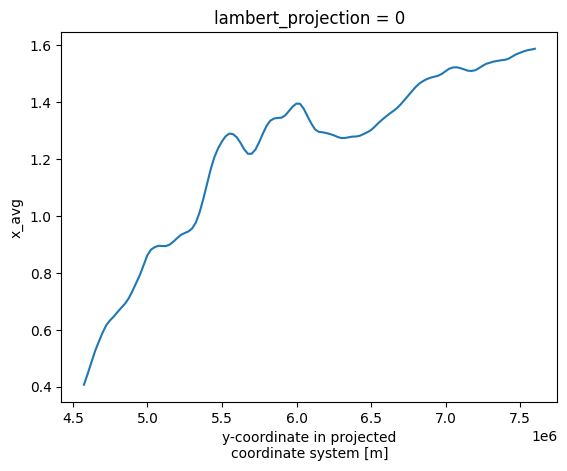

In [28]:
fig, ax = plt.subplots()
spatial_spinup_diag.visualize(result)

In [29]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    results = spatial_spinup_ens.apply(dt, ref=None)

[########################################] | 100% Completed | 17.09 s
[########################################] | 100% Completed | 50.40 s
[########################################] | 100% Completed | 40.88 s


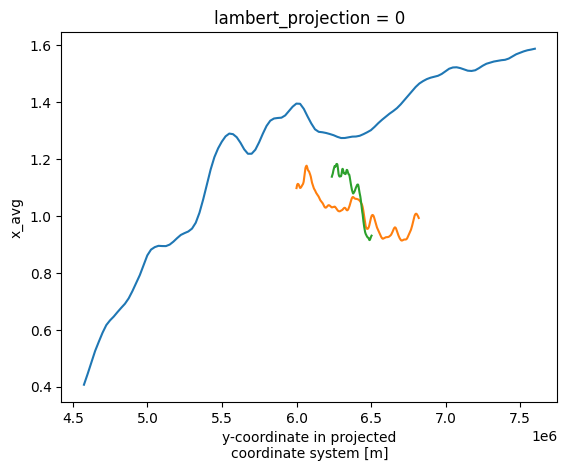

In [30]:
with ProgressBar():
    spatial_spinup_ens.visualize(results, facetted=False)

TODO:
- Add ERA5 data for comparison.
- Ideally this is only applied data of the same grid resolution?
- Number of time steps to average over


For this the level data needs to be in lat/lon coordinates.